# Introduction

This notebook details the structure of the library which will become common APIs for all methods as well as wrapper to help run the benchmark.

In [1]:
# path imports
import os
import sys

# Get the repo base path assuming you're in a notebook at root or in a subfolder
repo_root = os.path.abspath(os.path.join(os.getcwd(), ''))  # or add '..' to go up

# Add the benchmarks subdir to sys.path
bench_path = os.path.join(repo_root, 'benchmarks')
ddgclib_path = os.path.join(repo_root, 'ddgclib')
if [bench_path, ddgclib_path] not in sys.path:
    sys.path.append(bench_path)

## Base class for testing a collection of methods
First we import the `GeometryBenchmarkBase` class which is the base class for running a method on all benchmarks classes, and the `run_all_benchmarks` function which is used to run all benchmarks in the library.

For comparing different methods, every method should initiated its own class.

In [2]:
from benchmarks._benchmark_classes import run_all_benchmarks, GeometryBenchmarkBase

run_all_benchmarks

<function benchmarks._benchmark_classes.run_all_benchmarks(benchmark_classes, method=None, complex_dtype='vf')>

## Method Wrappers

In the cell below we speficy the example template methods, all available methods are saved in the `ddgclib._method_wrappers` module. The methods are used to compute curvature, area, and volume of the simplicial complexes.

E.g. currently there are template methods like:

```python
_curvature_i_methods = {
    "laplace-beltrami": compute_laplace_beltrami,
}

_area_i_methods = {
    "default": compute_area_vertex_default,
}

_area_ijk_methods = {
    "default": compute_area_triangle_default,
}

_area_methods = {
    "default": compute_area_triangle_default,
}

_volume_methods = {
    "default": compute_volume_default,
}
```

so we can specify a methods dict like:

In [3]:
method = {
    "curvature_i_method": "laplace-beltrami",
    "area_i_method": "default",
    "area_ijk_method": "default",
    "area_method": "default",
    "volume_method": "default",
}


The second important parameter is the `complex_dtype` which specifies the data type of the simplicial complex. It can be a hypect Complex object ('vv') or a tuple of numpy arrays (vertices, simplices) specified using 'vf' such as we have with `scipy`'s `Delaunay` function. The latter is intended for methods which cannot use dual vertices for whatever reason.

The final class can then be called like:

In [4]:
GeometryBenchmarkBase(method=method, complex_dtype='vv')

In [5]:
from ddgclib._method_wrappers import Curvature_i, Area_i, Area_ijk, Volume
curvature_i = Curvature_i()
area_i = Area_i()
area_ijk = Area_ijk()
volume = Volume()

## Geometry Benchmark Framework Overview

This section demonstrates the structure of a case geometry benchmark system designed to evaluate curvature, surface area, and volume computations on 3D simplicial complexes. Each benchmark case corresponds to a known geometry with analytical expressions.

---

## Required Functions for Any Benchmark Case

Each benchmark case (e.g., `TorusBenchmark`) should inherit from `GeometryBenchmarkBase` and implement the following:

### 1. `generate_mesh()`
Generates the mesh (vertices and simplices). For `'vf'` style, this is a 2-array representation:

```python
self.points      # shape (N, 3)
self.simplices   # shape (M, 3)
```

## Additional Analytical Tools (Implemented Per Benchmark)

These functions provide analytical evaluations to support local accuracy assessments. Each benchmark class should implement them when possible.

### `f(u, v)`

The parametric surface map $f:\mathbb{R}^2 \rightarrow \mathbb{R}^3$ from 2D domain to 3D:

$$
f(u, v) = (x(u, v), y(u, v), z(u, v))
$$

This maps a parametric domain (e.g., a UV grid) to the embedded 3D surface used for benchmarking.

---

### `H(u, v)`

Pointwise analytical **mean curvature**:

$$
H(u, v) = \text{analytical expression for mean curvature at } (u, v)
$$

This is used for comparing local curvature errors per vertex or triangle.

---

### `dA(uv_i, uv_j, uv_k)`

Computes the **integrated surface area** over a parametric triangle:

$$
\int_{\Omega} dA
$$

where \( \Omega \) is the triangle defined by parametric vertices \( uv_i, uv_j, uv_k \).

---

### `HNdA(uv_i, uv_j, uv_k)`

Computes the *integrated mean normal curvature* over a triangle area domain:

$$
\int_{\Omega} H(u, v) \bf{N} dA
$$

Useful for comparing discrete integrated curvature per simplex against analytical values.


## Visualization

Optionally all the test cases should have a simple visualization of the geometry, this will be especially later useful when we convert these to polyscope to better visualize local errors on the geometry.

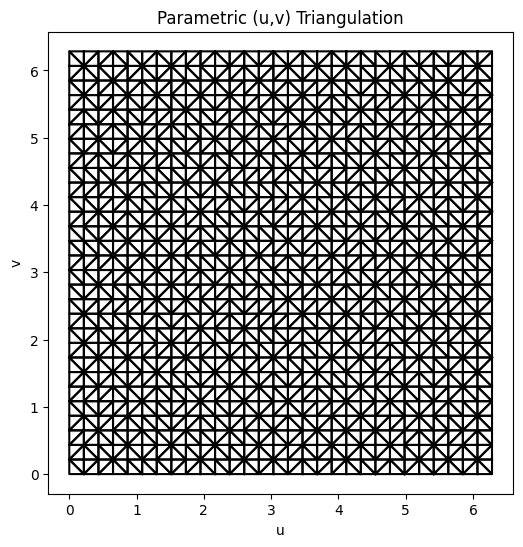

In [15]:
from benchmarks._benchmark_cases import TorusBenchmark

# Instantiate the benchmark
torus = TorusBenchmark(
    R_major=2.0,
    r_minor=1.0,
    n_u=30,
    n_v=30,
    method={  # method dict with per-quantity control
        "curvature_i_method": "laplace-beltrami",
        "area_i_method": "default",
        "area_ijk_method": "default",
        "area_method": "default",
        "volume_method": "default",
    },
    complex_dtype="vf"
)

# Torus generate mesh
torus.generate_mesh()
# Plot parametric (u,v) triangulation
torus.plot_uv_triangulation()


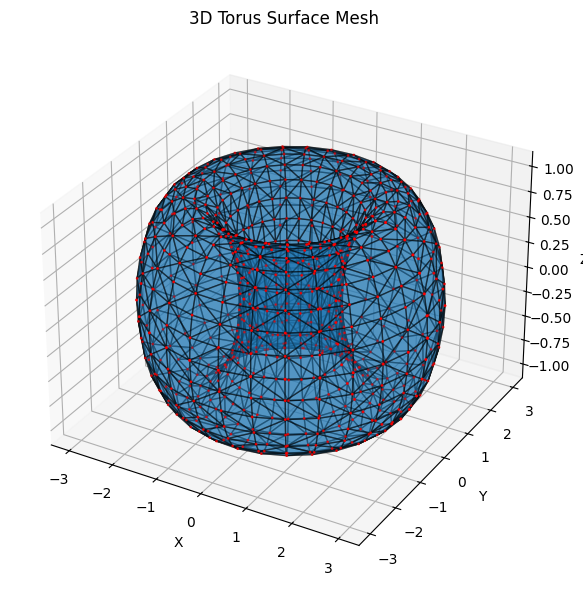

In [14]:

# Plot 3D surface mesh
torus.plot_surface_mesh()